# 텍스트 데이터 예측 Template

단어열 중의 단어를 예측.

```
... there was nothing else ( ??? ) do , so alice soon began ...
```



# 데이터

데이터 파일을 읽는다.

```
Alice's Adventures in Wonderland

                ALICE'S ADVENTURES IN WONDERLAND

                          Lewis Carroll

               THE MILLENNIUM FULCRUM EDITION 3.0

```

<br>

대문자를 소문자로 바꾸고 특수 문자 앞뒤에 스페이스를 둔다.

```
alice ' s adventures in wonderland

                alice ' s adventures in wonderland
```

<br>

스페이스를 기준으로 단어들을 분리한다. 특수문자도 단어로 취급한다.

```
['alice', "'", 's', 'adventures', 'in', 'wonderland', '', '', '', '', ...
```

<br>

빈 문자열을 삭제한다.

```
['alice', "'", 's', 'adventures', 'in', 'wonderland', ... 
```



<br>
단어 별 사전을 만든다.

```
{ ',': 0, 
  "'": 1, 
  'the': 2, 
  '`': 3, 
  '.': 4, 
  'and': 5
```

<br>

문장을 사전 인덱스로 변환.

```
['alice', "'", 's', 'adventures', 'in', 'wonderland', ...
[16, 1, 25, 431, 17, 700 ...
```

<br>

전체 21 단어 길이에서 한가운데 단어를 y로 하로 하고 나머지를 x로 샘플링 한다.


```
encoded = 51   2 52    18  154     345  6   53 0 40 17    200  94
raw =     down . there was nothing else to  do , so alice soon began

x =     [ 51   2 52    18  154     345  ( ) 53 0 40 17    200  94   ]
          down . there was nothing else ( ) do , so alice soon began 
y =                                     6
                                        to
```



## 다운로드

In [56]:
!wget https://raw.githubusercontent.com/dhrim/keras_howto_2021/master/data/alice_in_wonderland.txt

--2021-11-03 16:29:37--  https://raw.githubusercontent.com/dhrim/keras_howto_2021/master/data/alice_in_wonderland.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 172864 (169K) [text/plain]
Saving to: ‘alice_in_wonderland.txt’

alice_in_wonderland 100%[===================>] 168.81K  --.-KB/s    in 0.02s   

2021-11-03 16:29:37 (10.5 MB/s) - ‘alice_in_wonderland.txt’ saved [172864/172864]



파일 상단 20줄을 보면

In [57]:
!head -n 20 alice_in_wonderland.txt

Alice’s Adventures in Wonderland

by Lewis Carroll

CHAPTER I.
Down the Rabbit-Hole


Alice was beginning to get very tired of sitting by her sister on the
bank, and of having nothing to do: once or twice she had peeped into
the book her sister was reading, but it had no pictures or
conversations in it, “and what is the use of a book,” thought Alice
“without pictures or conversations?”

So she was considering in her own mind (as well as she could, for the
hot day made her feel very sleepy and stupid), whether the pleasure of
making a daisy-chain would be worth the trouble of getting up and
picking the daisies, when suddenly a White Rabbit with pink eyes ran
close by her.



In [58]:
!wc alice_in_wonderland.txt

  3710  29378 172864 alice_in_wonderland.txt


## 파일 로딩

텍스트 파일을 읽고

In [123]:
def load_raw_text_from_file(file_path):
  with open(file_path, 'r', encoding='utf-8') as fp: raw_text = fp.read()
  raw_text = raw_text.lower()
  return raw_text


In [124]:
import collections
from collections import OrderedDict

# 파일을 읽고
raw_text = load_raw_text_from_file('alice_in_wonderland.txt')

print("len(raw_text)=", len(raw_text))

print(raw_text[:100])


len(raw_text)= 162663
alice’s adventures in wonderland

by lewis carroll

chapter i.
down the rabbit-hole


alice was begi


In [125]:
VOCA_SIZE = 4000 # 어휘 사전의 크기

UNKNOWN = "UNKNOWN" # 어휘 사전 외의 단어 처리를 위해

## 단어 별로 쪼개기

스페이스 기준으로 단어들을 분리하기 전에 특수 기호 처리

In [126]:
raw_text = raw_text.replace("\n", " ")
raw_text = raw_text.replace("\"", " \" ")
raw_text = raw_text.replace("“", " “ ")
raw_text = raw_text.replace("’", " ’ ")
raw_text = raw_text.replace("'", " ' ")
raw_text = raw_text.replace("`", " ` ")
raw_text = raw_text.replace("!", " ! ")
raw_text = raw_text.replace("?", " ? ")
raw_text = raw_text.replace(".", " . ") 
raw_text = raw_text.replace(",", " , ")
raw_text = raw_text.replace(":", " : ")
raw_text = raw_text.replace("-", " - ")
raw_text = raw_text.replace(";", " ; ")
raw_text = raw_text.replace("[", " [ ")
raw_text = raw_text.replace("]", " ] ")
raw_text = raw_text.replace("(", " ( ")
raw_text = raw_text.replace(")", " ) ")
raw_text = raw_text.replace("_", " ")

In [127]:
# 스페이스를 기준으로 단어들로 분리
raw_words = raw_text.split(' ')
print("raw_words =", raw_words[:10])
# raw_words =  ['alice', '’', 's', 'adventures', 'in', 'wonderland', '', 'by', 'lewis', 'carroll' ...


# 분리된 단어들에서 빈 문자열 제거
raw_words = list(filter(("").__ne__, raw_words))   # 빈 문자열 "" 삭제


# 정리된 단어들 길이
print("len(raw_words) =", len(raw_words))

raw_words = ['alice', '’', 's', 'adventures', 'in', 'wonderland', '', 'by', 'lewis', 'carroll']
len(raw_words) = 38538


## 인코딩

### 사전 만들기

In [128]:
# 빈도 순으로 정열
counts = collections.Counter(raw_words)
sorted_raw_words = sorted(raw_words, key=counts.get, reverse=True)
print("sorted_raw_words =", sorted_raw_words[:10])
# sorted_raw_words = [',', ',', ',', ',', ',', ',', ',', ',', ',', ','


# 단어 중복 삭제
sorted_raw_words = list(OrderedDict.fromkeys(sorted_raw_words))
print("len(sorted_raw_words) =", len(sorted_raw_words))

# voca 크기 이상의 단어는 버린다.
sorted_raw_words = sorted_raw_words[:VOCA_SIZE]
print("len(sorted_raw_words) =", len(sorted_raw_words))
sorted_raw_words.append(UNKNOWN)

print("sorted_raw_words =", sorted_raw_words[:20])
# sorted_raw_words = [',', 'the', '.', '“', '”', 'and', ... ]

word2index = { word:index for index,word in enumerate(sorted_raw_words)}
index2word = { index:word for index,word in enumerate(sorted_raw_words)}
print("word2index =", word2index)
# word2index = {',': 0, 'the': 1, '.': 2, '“': 3, '”': 4, 'and': 5, ... }


sorted_raw_words = [',', ',', ',', ',', ',', ',', ',', ',', ',', ',']
len(sorted_raw_words) = 3235
len(sorted_raw_words) = 3235
sorted_raw_words = [',', 'the', '.', '“', '”', 'and', 'to', '’', 'a', 'of', 'it', 'she', 'i', 'you', 'said', '!', 'in', 'alice', 'was', 'that']
word2index = {',': 0, 'the': 1, '.': 2, '“': 3, '”': 4, 'and': 5, 'to': 6, '’': 7, 'a': 8, 'of': 9, 'it': 10, 'she': 11, 'i': 12, 'you': 13, 'said': 14, '!': 15, 'in': 16, 'alice': 17, 'was': 18, 'that': 19, 'as': 20, 'her': 21, ':': 22, 'with': 23, 'at': 24, 't': 25, '-': 26, 's': 27, 'on': 28, '?': 29, 'all': 30, ';': 31, 'had': 32, 'this': 33, 'for': 34, 'not': 35, 'but': 36, 'be': 37, 'or': 38, 'they': 39, 'so': 40, 'very': 41, 'what': 42, 'little': 43, 'he': 44, 'is': 45, 'out': 46, 'if': 47, 'one': 48, 'up': 49, 'about': 50, 'down': 51, 'there': 52, 'do': 53, 'his': 54, 'no': 55, 'gutenberg': 56, 'then': 57, 'have': 58, 'like': 59, 'were': 60, 'project': 61, 'by': 62, 'would': 63, 'went': 64, 'herself': 65, 'them

### 인코딩 실행
문장을 사전 index 번호로 인코딩

In [129]:
encoded_words = []
for word in raw_words:
  if not word in word2index: word = UNKNOWN
  encoded_words.append(word2index[word])

print("raw_words =", raw_words[:20])
# raw_words = ['alice', '’', 's', 'adventures', 'in', ...
print("encoded_words =", encoded_words[:20])
# encoded_words = [18, 7, 28, 536, 17, 777, ...

raw_words = ['alice', '’', 's', 'adventures', 'in', 'wonderland', 'by', 'lewis', 'carroll', 'chapter', 'i', '.', 'down', 'the', 'rabbit', '-', 'hole', 'alice', 'was', 'beginning']
encoded_words = [17, 7, 27, 535, 16, 776, 62, 1700, 1701, 343, 12, 2, 51, 1, 112, 26, 777, 17, 18, 292]


## 학습 데이터 샘플링

In [130]:
WINDOW_SIZE = 12

In [131]:
raw_x = []
raw_y = []

HALF_WINDOW_SIZE = int(WINDOW_SIZE/2)
DO_SHOW_SAMPEL = True

#     A B C D E F G H I J K L M N O P Q R S T U V W X Y Z
#     <------->( )<------->
#
# x = A B C D E   G H I J K
# y =           F

s_x = None
s_y = None
s = None
for i in range(len(encoded_words)):
  if i + HALF_WINDOW_SIZE + 1 + HALF_WINDOW_SIZE - 1 >= len(encoded_words): break
  a_x = []
  a_x.extend(encoded_words[i:i+HALF_WINDOW_SIZE])
  a_x.extend(encoded_words[i+HALF_WINDOW_SIZE+1:i+WINDOW_SIZE+1])
  raw_x.append(a_x)
  raw_y.append(encoded_words[i+HALF_WINDOW_SIZE])
  if i==940 and DO_SHOW_SAMPEL:
    print(" ".join(raw_words[i:i+WINDOW_SIZE+1]))
    print(raw_words[i+HALF_WINDOW_SIZE])
    print(encoded_words[i:i+WINDOW_SIZE+1])
    print(raw_x[-1])
    print(raw_y[-1])

['down', '.', 'there', 'was', 'nothing', 'else']
['do', ',', 'so', 'alice', 'soon', 'began']
down . there was nothing else to do , so alice soon began
to
[51, 2, 52, 18, 154, 345, 6, 53, 0, 40, 17, 200, 94]
[51, 2, 52, 18, 154, 345, 53, 0, 40, 17, 200, 94]
6


In [132]:
import numpy as np
raw_x = np.array(raw_x)
raw_y = np.array(raw_y)

print(raw_x.shape)
print(raw_y.shape)

(38526, 12)
(38526,)


## 학습 / 성능 데이터 나누기

In [188]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(raw_x, raw_y, test_size=0.1, shuffle=True)

## 준비된 데이터

입력 x는 12개 순차열 단어이며, 실제 값은 각 단어의 사전 index 이다.

출력 y값 역시 빠진 괄호의 단어에 해당하는 사전 index값을 y로 한다.

In [189]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(34673, 12)
(34673,)
(3853, 12)
(3853,)


In [169]:
print(train_x[:5])
print(train_y[:5])

[[  69   11   18    8   43 1474 2339    1  586  152  394   28]
 [ 545   10   32  151    2   36  429  255  317  113   20   11]
 [  12  178   59    6 1015   13    8   43  484   26 1900 1901]
 [  57  141    8   43  996    9   28    1  949    2   17  281]
 [  17 1082   21  358    0    5   22  206    3   13   74  230]]
[ 62  21  15 235  94]


생성된 데이터를 보면

In [134]:
def decode(x, y, truth=None):
  decoded = []
  for i in range(HALF_WINDOW_SIZE):
    decoded.append(index2word[x[i]])
  decoded.append("( ??? )")
  for i in range(HALF_WINDOW_SIZE,WINDOW_SIZE):
    decoded.append(index2word[x[i]])
  decoded.append("  PREDICTED={}".format(index2word[y]))
  if truth != None:
    decoded.append(" TRUTH={}".format(index2word[truth]))
  return decoded

print(" ".join(decode(train_x[0], train_y[0], train_y[0])))


sent to the project gutenberg literary ( ??? ) foundation at the address specified in   PREDICTED=archive


# Template

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 12, 32)            128000    
_________________________________________________________________
dropout_28 (Dropout)         (None, 12, 32)            0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 256)               164864    
_________________________________________________________________
batch_normalization_9 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_29 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 100)               25700     
_________________________________________________________________
batch_normalization_10 (Batc (None, 100)              

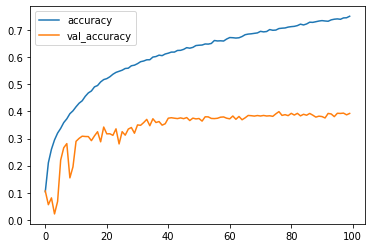

121/121 [==============================] - 1s 4ms/step - loss: 5.1290 - accuracy: 0.3880
loss = 5.129027843475342
acc = 0.38800933957099915
i ’ ve so often read ( ??? ) the newspapers , at the end   PREDICTED=on  TRUTH=in
. alice thought this a very ( ??? ) thing , and she went nearer   PREDICTED=large  TRUTH=curious
a long and a sad tale ( ??? ) ” said the mouse , turning   PREDICTED=,  TRUTH=!
get hold of anything , but ( ??? ) heard a little shriek and a   PREDICTED=she  TRUTH=she
with the permission of the copyright ( ??? ) , your use and distribution must   PREDICTED=holder  TRUTH=holder
perhaps not , ” said alice ( ??? ) a soothing tone : “ don   PREDICTED=,  TRUTH=in
. ” she got up and ( ??? ) to the table to measure herself   PREDICTED=ran  TRUTH=went
little startled by seeing the cheshire ( ??? ) sitting on a bough of a   PREDICTED=down  TRUTH=cat
on her face like the three ( ??? ) , but she could not remember   PREDICTED=of  TRUTH=gardeners
all liability to you for damages ( 

In [193]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Bidirectional, LSTM
from tensorflow.keras.callbacks import ReduceLROnPlateau

EMBEDDING_SIZE = 32 # 단어를 임베딩할 벡터 크기

model = Sequential()
model.add(Input(WINDOW_SIZE))
model.add(Embedding(VOCA_SIZE, EMBEDDING_SIZE))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(128)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(100, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(VOCA_SIZE, activation="softmax"))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(train_x, train_y, batch_size=64, epochs=100, validation_split=0.1)


# 성능 그래프 그리기
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label="accuracy")
plt.plot(history.history['val_accuracy'], label="val_accuracy")
plt.legend()
plt.show()



# 평가
loss, acc = model.evaluate(test_x, test_y)
print("loss =", loss)
print("acc =", acc)


# 실제 예측
y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=-1)

for i in range(10):
  print(" ".join(decode(test_x[i], predicted[i], test_y[i])))

# 오버피팅 처리 안했을 때

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 12, 32)            128000    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 256)               164864    
_________________________________________________________________
dense_22 (Dense)             (None, 100)               25700     
_________________________________________________________________
dense_23 (Dense)             (None, 4000)              404000    
Total params: 722,564
Trainable params: 722,564
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
488/488 [==============================] - 8s 10ms/step - loss: 6.0892 - accuracy: 0.0651 - val_loss: 5.8713 - val_accuracy: 0.0649
Epoch 2/50
488/488 [==============================] - 4s 8ms/step - loss: 5.6652 - accuracy: 0.0675 - 

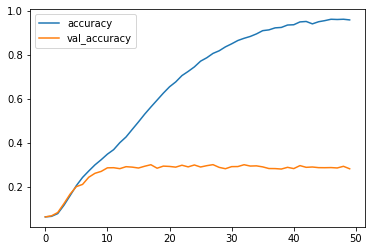

121/121 [==============================] - 1s 4ms/step - loss: 14.2098 - accuracy: 0.2834
loss = 14.209758758544922
acc = 0.2834155261516571
i ’ ve so often read ( ??? ) the newspapers , at the end   PREDICTED=with  TRUTH=in
. alice thought this a very ( ??? ) thing , and she went nearer   PREDICTED=little  TRUTH=curious
a long and a sad tale ( ??? ) ” said the mouse , turning   PREDICTED=!  TRUTH=!
get hold of anything , but ( ??? ) heard a little shriek and a   PREDICTED=he  TRUTH=she
with the permission of the copyright ( ??? ) , your use and distribution must   PREDICTED=trademark  TRUTH=holder
perhaps not , ” said alice ( ??? ) a soothing tone : “ don   PREDICTED=in  TRUTH=in
. ” she got up and ( ??? ) to the table to measure herself   PREDICTED=see  TRUTH=went
little startled by seeing the cheshire ( ??? ) sitting on a bough of a   PREDICTED=thought  TRUTH=cat
on her face like the three ( ??? ) , but she could not remember   PREDICTED=dish  TRUTH=gardeners
all liability to you fo

In [196]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Bidirectional, LSTM
from tensorflow.keras.callbacks import ReduceLROnPlateau

EMBEDDING_SIZE = 32 # 단어를 임베딩할 벡터 크기

model = Sequential()
model.add(Input(WINDOW_SIZE))
model.add(Embedding(VOCA_SIZE, EMBEDDING_SIZE))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(100, activation="relu"))
model.add(Dense(VOCA_SIZE, activation="softmax"))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(train_x, train_y, batch_size=64, epochs=50, validation_split=0.1)


# 성능 그래프 그리기
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label="accuracy")
plt.plot(history.history['val_accuracy'], label="val_accuracy")
plt.legend()
plt.show()



# 평가
loss, acc = model.evaluate(test_x, test_y)
print("loss =", loss)
print("acc =", acc)


# 실제 예측
y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=-1)

for i in range(10):
  print(" ".join(decode(test_x[i], predicted[i], test_y[i])))